In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import math
from itertools import chain
import itertools
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd.function import Function
import torch.nn.utils.prune as prune
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fftshift

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn, einsum
import logging
from functools import partial
from collections import OrderedDict
import seaborn as sns
import matplotlib as mp
import time
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler



import importlib
import sys

sys.path.append('../src')
from utils import data_handler
from utils import benchmark
from utils import visualisation
from models.VQ_VAE_2 import Model
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

import json
from tqdm import tqdm


import pickle


# instead, we plug in our OWN datasets

In [2]:
suggested_genes_file_1 = '../../data/PD_genes_of_interest/signif_de_Disease_status_IDIOPATHIC_PD_01.tsv'
suggested_genes_file_2 = '../../data/PD_genes_of_interest/signif_de_PD_DIAGNOSIS_0.1.tsv'

not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
selecting genes based on median absolute deviation threshold:  5 ...
min MAD 0.0
max MAD 4194.0


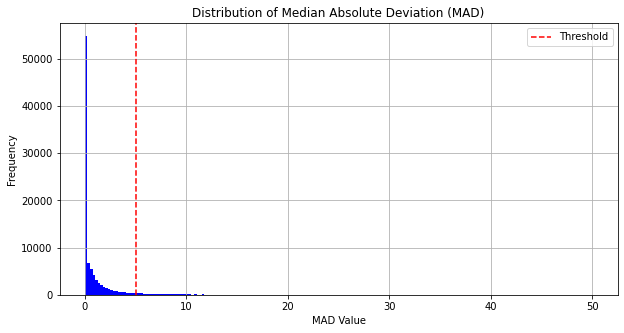

removing 89395 genes under the MAD threshold from the dataset
number of genes selected :  5914
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series
not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
selecting genes based on median absolute deviation threshold:  2 ...
min MAD 0.0
max MAD 4192.0999999999985


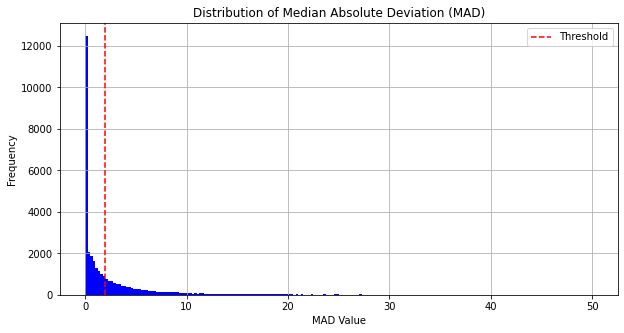

removing 22641 genes under the MAD threshold from the dataset
number of genes selected :  11928
log(1 + x) transformation...
scaling to [0, 1]...
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


In [4]:
# experiment 1
data_1, metadata_1 = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = None)

data_2, metadata_2 = data_handler.generate_dataset(
    feature_selection_threshold = 2, 
    gene_selection_file = None)


with open('../workfiles/experiment_1.pkl', 'wb') as f:
    pickle.dump((data_1, metadata_1, data_2, metadata_2), f)

In [ ]:
# Load the data and metadata back from the pickle file
with open('../workfiles/experiment_1.pkl', 'rb') as f:
    data_1, metadata_1, data_2, metadata_2 = pickle.load(f)


In [ ]:
# experiment 1
data_1, metadata_1 = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = suggested_genes_file_1)

data_2, metadata_2 = data_handler.generate_dataset(
    feature_selection_threshold = 2, 
    gene_selection_file = suggested_genes_file_1)


with open('../workfiles/experiment_2.pkl', 'wb') as f:
    pickle.dump((data_1, metadata_1, data_2, metadata_2), f)

In [ ]:
# Load the data and metadata back from the pickle file
with open('../workfiles/experiment_2.pkl', 'rb') as f:
    data_1, metadata_1, data_2, metadata_2 = pickle.load(f)


In [ ]:
# experiment 1
data_1, metadata_1 = data_handler.generate_dataset_transcripts(
    feature_selection_threshold = 5, 
    gene_selection_file = suggested_genes_file_2)

data_2, metadata_2 = data_handler.generate_dataset(
    feature_selection_threshold = 2, 
    gene_selection_file = suggested_genes_file_2)


with open('../workfiles/experiment_3.pkl', 'wb') as f:
    pickle.dump((data_1, metadata_1, data_2, metadata_2), f)

In [ ]:
# Load the data and metadata back from the pickle file
with open('../workfiles/experiment_3.pkl', 'rb') as f:
    data_1, metadata_1, data_2, metadata_2 = pickle.load(f)


In [5]:


feature_num_1 = data_1.shape[1]
data_num_1 = data_1.shape[0]
dat_1 = data_1.reshape(-1,1,feature_num_1)

feature_num_2 = data_2.shape[1]
data_num_2 = data_2.shape[0]
dat_2 = data_2.reshape(-1,1,feature_num_2)

## End of experiment choice

In [ ]:
print(dat_1.shape)
print(dat_2.shape)



In [ ]:
class Mydatasets(torch.utils.data.Dataset):
    def __init__(self, data1, data2 ,transform = None):
        self.transform = transform
        self.data1 = data1
        self.data2 = data2
        self.datanum = len(data1)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        
        out_data1 = torch.tensor(self.data1[idx]).float()
        out_data2 = torch.tensor(self.data2[idx]).float()
        if self.transform:
            out_data1 = self.transform(out_data1)
            out_data2 = self.transform(out_data2)

        return out_data1,out_data2

In [ ]:
train_1, test_1 = train_test_split(dat_1, test_size = 0.1,random_state = 66)
print('train_data_1:',len(train_1))
print('test_data_1:',len(test_1))

train_2, test_2 = train_test_split(dat_2, test_size = 0.1,random_state = 66)
print('train_data_2:',len(train_2))
print('test_data_2:',len(test_2))

train_data_set = Mydatasets(data1 = train_1, data2 = train_2)
test_data_set = Mydatasets(data1 = test_1, data2 = test_2)

train_dataloader = torch.utils.data.DataLoader(train_data_set, batch_size = 256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data_set, batch_size = 64, shuffle=False)

## Preping labels

In [ ]:
metadata_path = "../../METADATA_200123.xlsx"

meta_data = pd.read_excel(metadata_path, header = 1, usecols = range(1,10) )
patient_ids = [int(name.split(".")[1]) for name in filenames]

# Create a dictionary to map 'Patient Number' to 'Disease Status'
patient_disease_status = dict(zip(meta_data['Patient Number'], meta_data['Disease Status']))

label = [patient_disease_status.get(patient_id, None) for patient_id in patient_ids]
label = pd.Series(label)
num_classes = len(pd.Series(label).unique())

### Loading Model

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("mps")

VQ_VAE = Model(
            dropout = 0.0,
            num_classes = num_classes,
            input_size_1 = feature_num_1,
            input_size_2 = feature_num_2,
            encoder_dim_b = 64,
            encoder_dim_t = 32,
            num_embeddings_b = 64,
            num_embeddings_t = 32,
            embedding_dim_b = 64,
            embedding_dim_t = 32, 
            commitment_cost = 1
           ).to(DEVICE)

Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(VQ_VAE.parameters(), lr=1e-4, amsgrad=False)
data_variance_1 = np.var(dat_1)
data_variance_2 = np.var(dat_2)

#VQ_VAE.load_state_dict(torch.load('VQ_2_disc'),strict=False)
print(DEVICE)

we need a proper training function


In [ ]:
EPOCH = 200
train_res_recon_error = []
train_res_perplexity = []

loss_list = []
val_loss_list = []
ac_list = []
VQ_VAE.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    quantized_merge = torch.empty(0, 1, 64).to(DEVICE)

    for _, (inputs1, inputs2) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()
        inputs1 = inputs1.to(DEVICE)
        inputs2 = inputs2.to(DEVICE)
        vq_loss_b, vq_loss_t, recon_b, recon_b2, recon_t, z_b, z_final, quantized_b, perplexity, variance_z_b = VQ_VAE(inputs1, inputs2)
        recon_error_b = F.mse_loss(recon_b, inputs1) / data_variance_1
        recon_error_b2 = F.mse_loss(recon_b2, inputs2) / data_variance_2
        recon_error_t = F.mse_loss(recon_t, z_b) / variance_z_b
        loss = recon_error_b + recon_error_b2 + recon_error_t + vq_loss_b + vq_loss_t
        loss.backward()
        optimizer.step()
        count += 1

        # Append the training loss values for monitoring
        train_res_recon_error.append(recon_error_b.item() + recon_error_t.item())
        train_res_perplexity.append(perplexity.item())

        # Print training statistics


# After training, you can print or log other relevant information as needed
print('Training completed.')
plt.plot(train_res_recon_error)

In [ ]:
en_lat = []
en_quantized = []
en_labels = []

data_set = Mydatasets(data1 = dat_1, data2 = dat_2)
data_set = torch.utils.data.DataLoader(data_set, batch_size = 256, shuffle=True)

for i in range(len(dat_1)):
    en_data1 = data_set.dataset[i][0]
    en_data2 = data_set.dataset[i][1]

    _, _, _, _, _, latent_1, latent_2, _, _, _ = VQ_VAE(en_data1.view(1, 1, feature_num_1).float().to(DEVICE), en_data2.view(1, 1, feature_num_2).float().to(DEVICE))
    en_quantized.append(latent_2.cpu().detach().numpy())
    en_lat.append(latent_1.cpu().detach().numpy())
    en_quantized.append(latent_2.cpu().detach().numpy())

encode_out = np.array(en_lat)
encode_out = encode_out.reshape(len(dat_1), -1)
quantized_out = np.array(en_quantized)
quantized_out = quantized_out.reshape(len(dat_1), -1)
print('encode_out:', encode_out.shape)
print('quantized_out:', quantized_out.shape)

latent_Z = encode_out

In [ ]:
# compatibility between notebooks
compressed_dataframe = encode_out

# First, analyse all groups

In [ ]:
import helpers
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            #"perplexity" : 75, 
            "perplexity" : 100, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
visualisation.plot_clusters(compressed_dataframe, label, TSNE_params)
benchmark.print_metrics(compressed_dataframe, label)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(compressed_dataframe)
visualisation.plot_clusters(compressed_dataframe, kmeans_labels, TSNE_params)
benchmark.print_metrics(compressed_dataframe, kmeans_labels)



## Second, Check if control group leads to any clusters 

In [ ]:
# filtering data
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Healthy Control"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

In [ ]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
TSNE_params = {
            "early_exaggeration" : 50,
            "learning_rate" : 500, 
            "perplexity" : 50, 
            "min_grad_norm" : 1e-7, 
            "n_iter" : 2000,
            "n_components" : 2
        }
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
benchmark.print_metrics(filtered_dat, kmeans_labels)



## Third : check for clusters in the Idiopathic PD group

In [ ]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Idiopathic PD"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

In [ ]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
params = {"early_exaggeration":10,
              "learning_rate":700, 
              "perplexity":15, 
              "min_grad_norm":1e-7, 
              "n_iter":1000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)

print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
benchmark.print_metrics(filtered_dat, kmeans_labels)

## Last : Check for Genetic PD groups

In [ ]:
# filtering data
# Convert clinical_info and filenames to Series for easy filtering
clinical_info_series = pd.Series(label)
filenames_series = pd.Series(filenames)

# Create boolean masks for filtering
clinical_mask = clinical_info_series == "Genetic PD"


# Apply the mask to your dataset
filtered_dat = compressed_dataframe[clinical_mask]
filtered_clinical_info = clinical_info_series[clinical_mask]

# Check the shape of the filtered dataset
print(filtered_dat.shape)
print(filtered_clinical_info.shape)

In [ ]:
importlib.reload(visualisation)
importlib.reload(helpers)

print("######################## OG Groups : ")
params = {"early_exaggeration":5,
              "learning_rate":100, 
              "perplexity":30, 
              "min_grad_norm":1e-7, 
              "n_iter":5000,
              "n_components":2}
visualisation.plot_clusters(filtered_dat, filtered_clinical_info, TSNE_params)


print("######################## KNMEANS : ")
kmeans_labels = helpers.auto_kMean(filtered_dat)
visualisation.plot_clusters(filtered_dat, kmeans_labels, TSNE_params)
benchmark.print_metrics(filtered_dat, kmeans_labels)